In [1]:
# toc
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# tensorflow/keras
# this is the new preferring method of importing according to tensorflow
# See https://github.com/tensorflow/tensorflow/issues/53144
from keras.api.models import Sequential
from keras.api.layers import Dense, Input, Dropout
from keras.api.regularizers import l2
from keras.api.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as k
import tensorflow as tf

tf.config.set_visible_devices([], 'GPU')
plt.style.use('../maroon_ipynb.mplstyle')

# Problem 1
Included with the homework is a file containing a number of metrics for different car models. The columns are, in order, the fuel economy in MPG, number of cylinders, displacement, horsepower, weight, acceleration, model year, and place of origin (1 is USA, 2 is Europe, and 3 is Japan). The goal of this assignment will be to create a neural network regression model that can predict fuel economy.

You will notice some of the horsepower values are missing. Remove those entries from the database. For the remaining database, construct a neural network that takes the 7 non-MPG values as an input. To begin with, use a single hidden layer of 64 neurons and an 80/20 train/test split and try to minimize the mean squared error for a test set of data (not the data you trained on). Show the evolution of the training and validation error as a function of epoch.

## Solution
Let's get the data loaded.

In [2]:
columns = [
    "mpg",
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model_year",
    "origin",
    "car_name"
]

# I removed the rows with no horsepower values
df = pd.read_csv('auto-mpg.data', sep=r'\s+', names=columns)

# Drop the car name
df = df.drop(columns=['car_name'])

# Separate features and target
features = df.drop(columns=['mpg'])
target = df['mpg']

# Get training and testing data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# Scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

df.head().transpose()

,0,1,2,3,4
mpg,18.0,15.0,18.0,16.0,17.0
cylinders,8.0,8.0,8.0,8.0,8.0
displacement,307.0,350.0,318.0,304.0,302.0
horsepower,130.0,165.0,150.0,150.0,140.0
weight,3504.0,3693.0,3436.0,3433.0,3449.0
acceleration,12.0,11.5,11.0,12.0,10.5
model_year,70.0,70.0,70.0,70.0,70.0
origin,1.0,1.0,1.0,1.0,1.0


Now we can create our model that has 64 neurons in the hidden layer and a single output neuron. The input layer is the number of feature columns we have, which is 7.

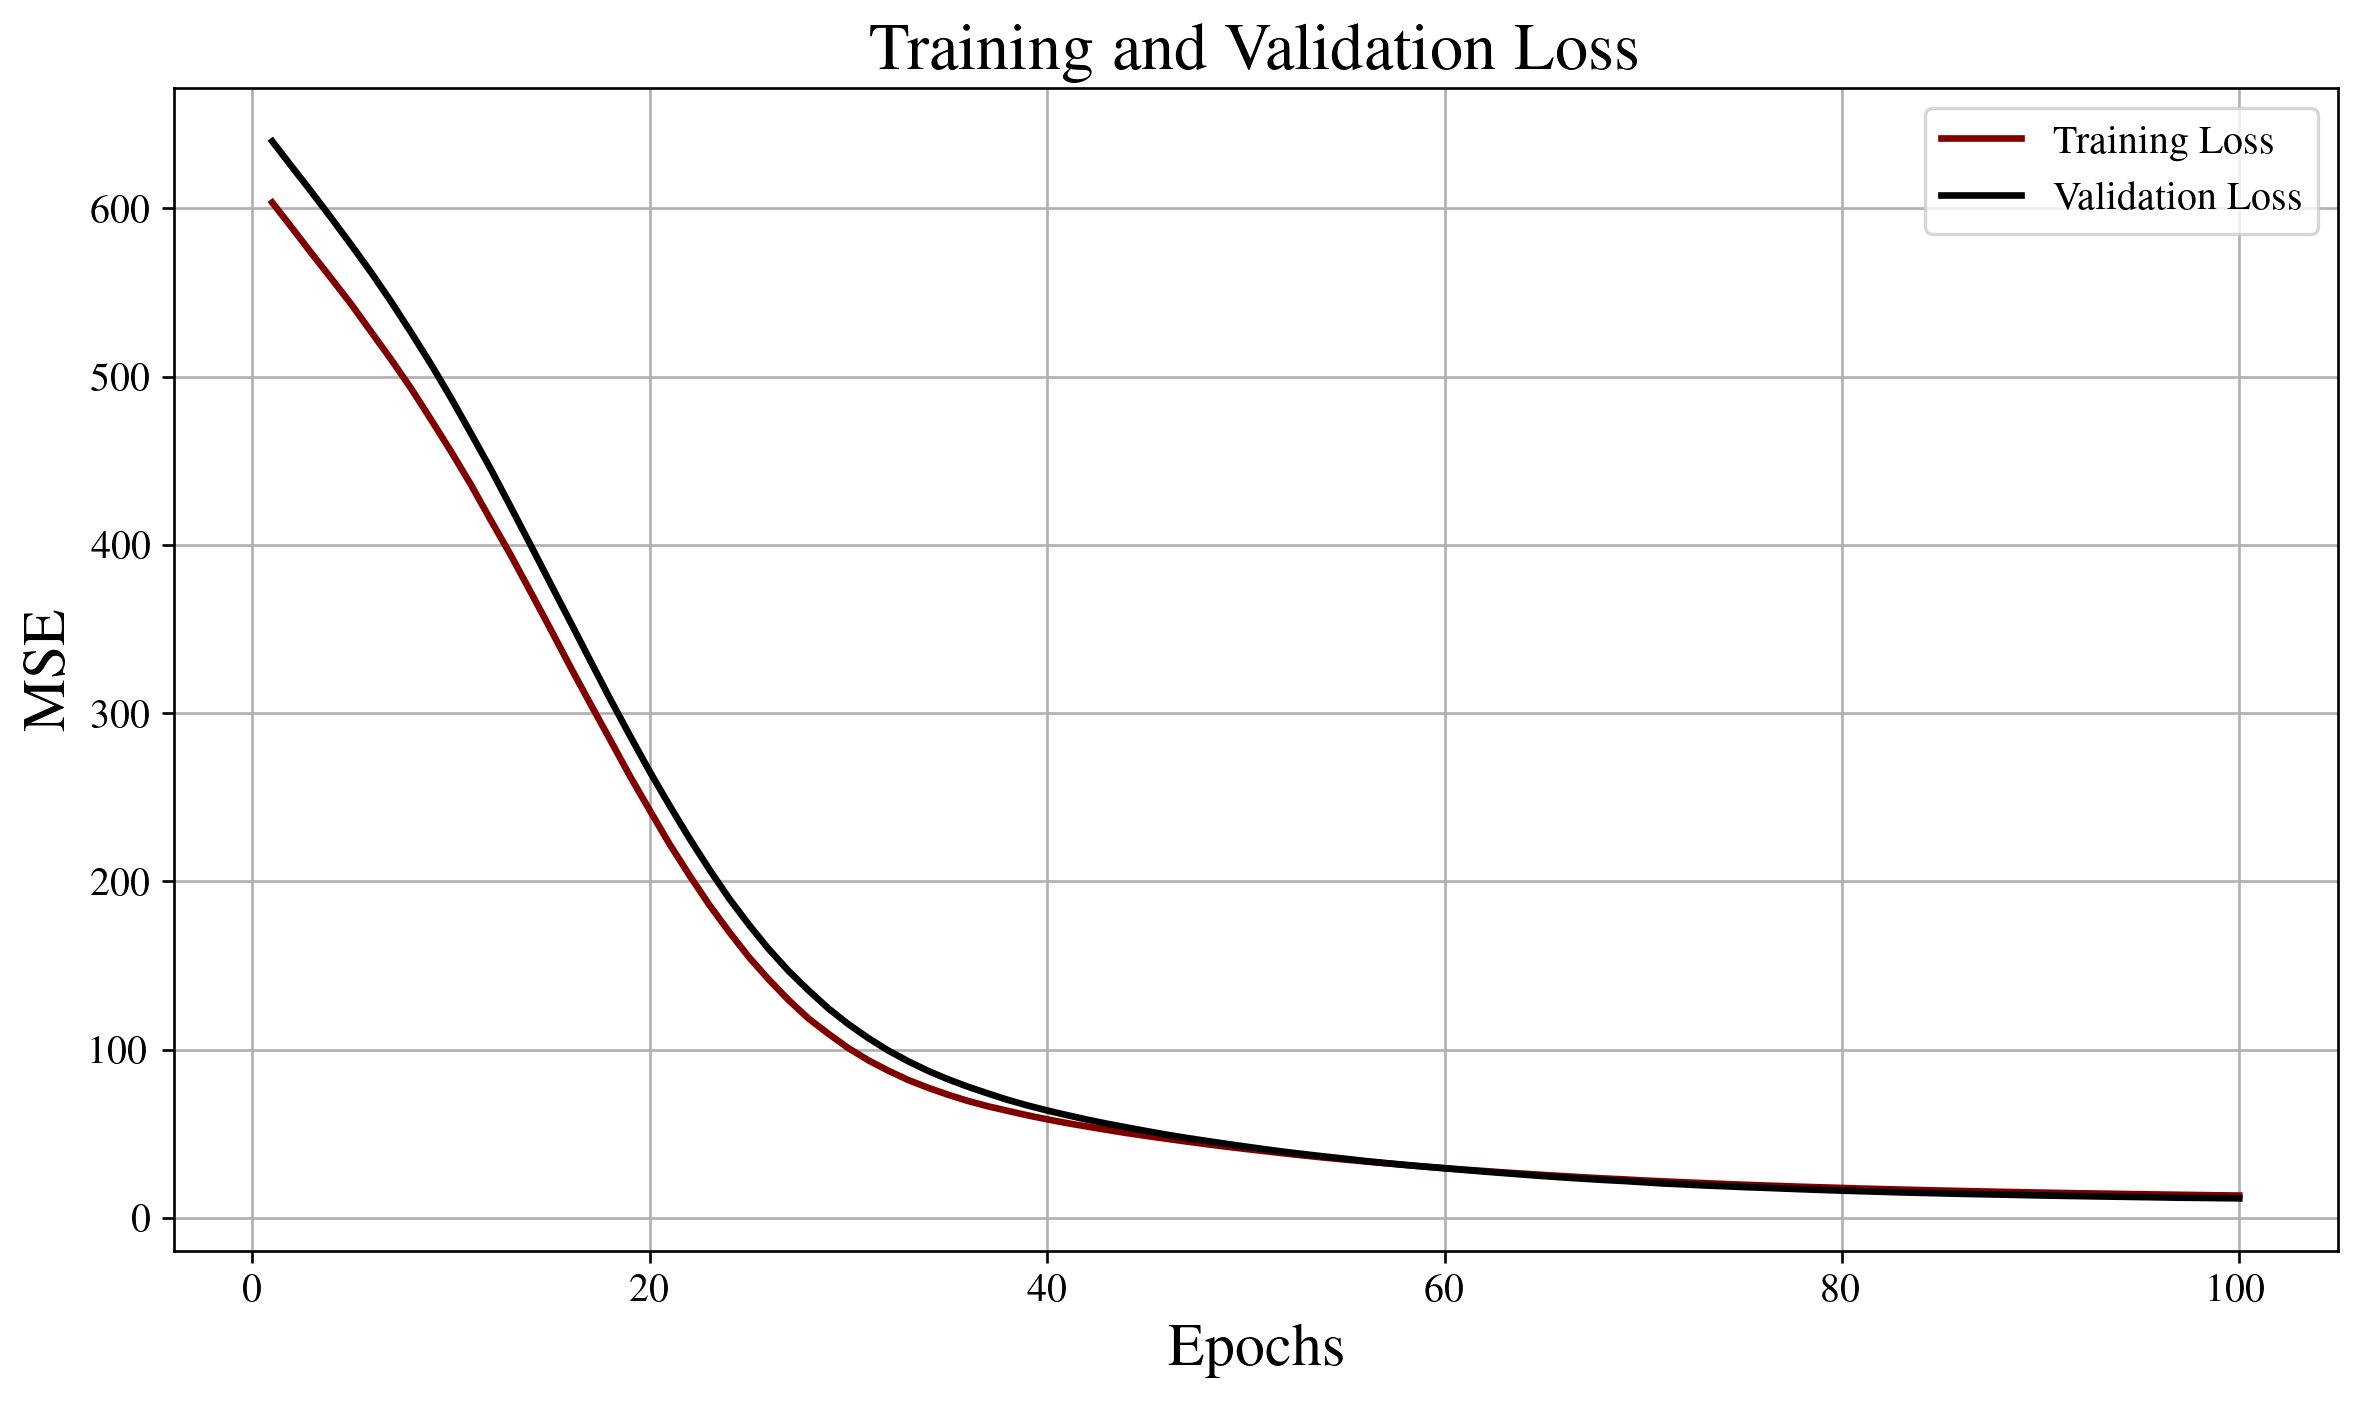

In [3]:
# Make and train the model
k.clear_session()
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), verbose=False)

# Get the training and validation loss
epochs = np.array(history.epoch) + 1
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label='Training Loss')
ax.plot(epochs, val_loss, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')
ax.set_title('Training and Validation Loss')
ax.legend()
plt.show()

If you don't normalize the features, then this graph will be very different each time. The training loss will be much higher in the beginning depending on the initial random weights, but normalizing helps to keep the scale consistent.

# Problem 2
Vary the batch size over at least an order of magnitude and see how it affects the training. What batch size converges the fastest? What differences do you observe in the training?

## Solution
We can iterate through a list of batch sizes and train the model for each one. We need to capture the time for this as well and observe the trends. Note: The batch size should not be greater than the number of training samples.

Batch Size: 8, Training Time: 3.44 sec, Final Training Loss: 6.7311
Batch Size: 16, Training Time: 2.88 sec, Final Training Loss: 7.9450
Batch Size: 32, Training Time: 2.49 sec, Final Training Loss: 12.5246
Batch Size: 64, Training Time: 2.29 sec, Final Training Loss: 37.9574
Batch Size: 128, Training Time: 2.19 sec, Final Training Loss: 102.6519
Batch Size: 256, Training Time: 2.19 sec, Final Training Loss: 226.4905


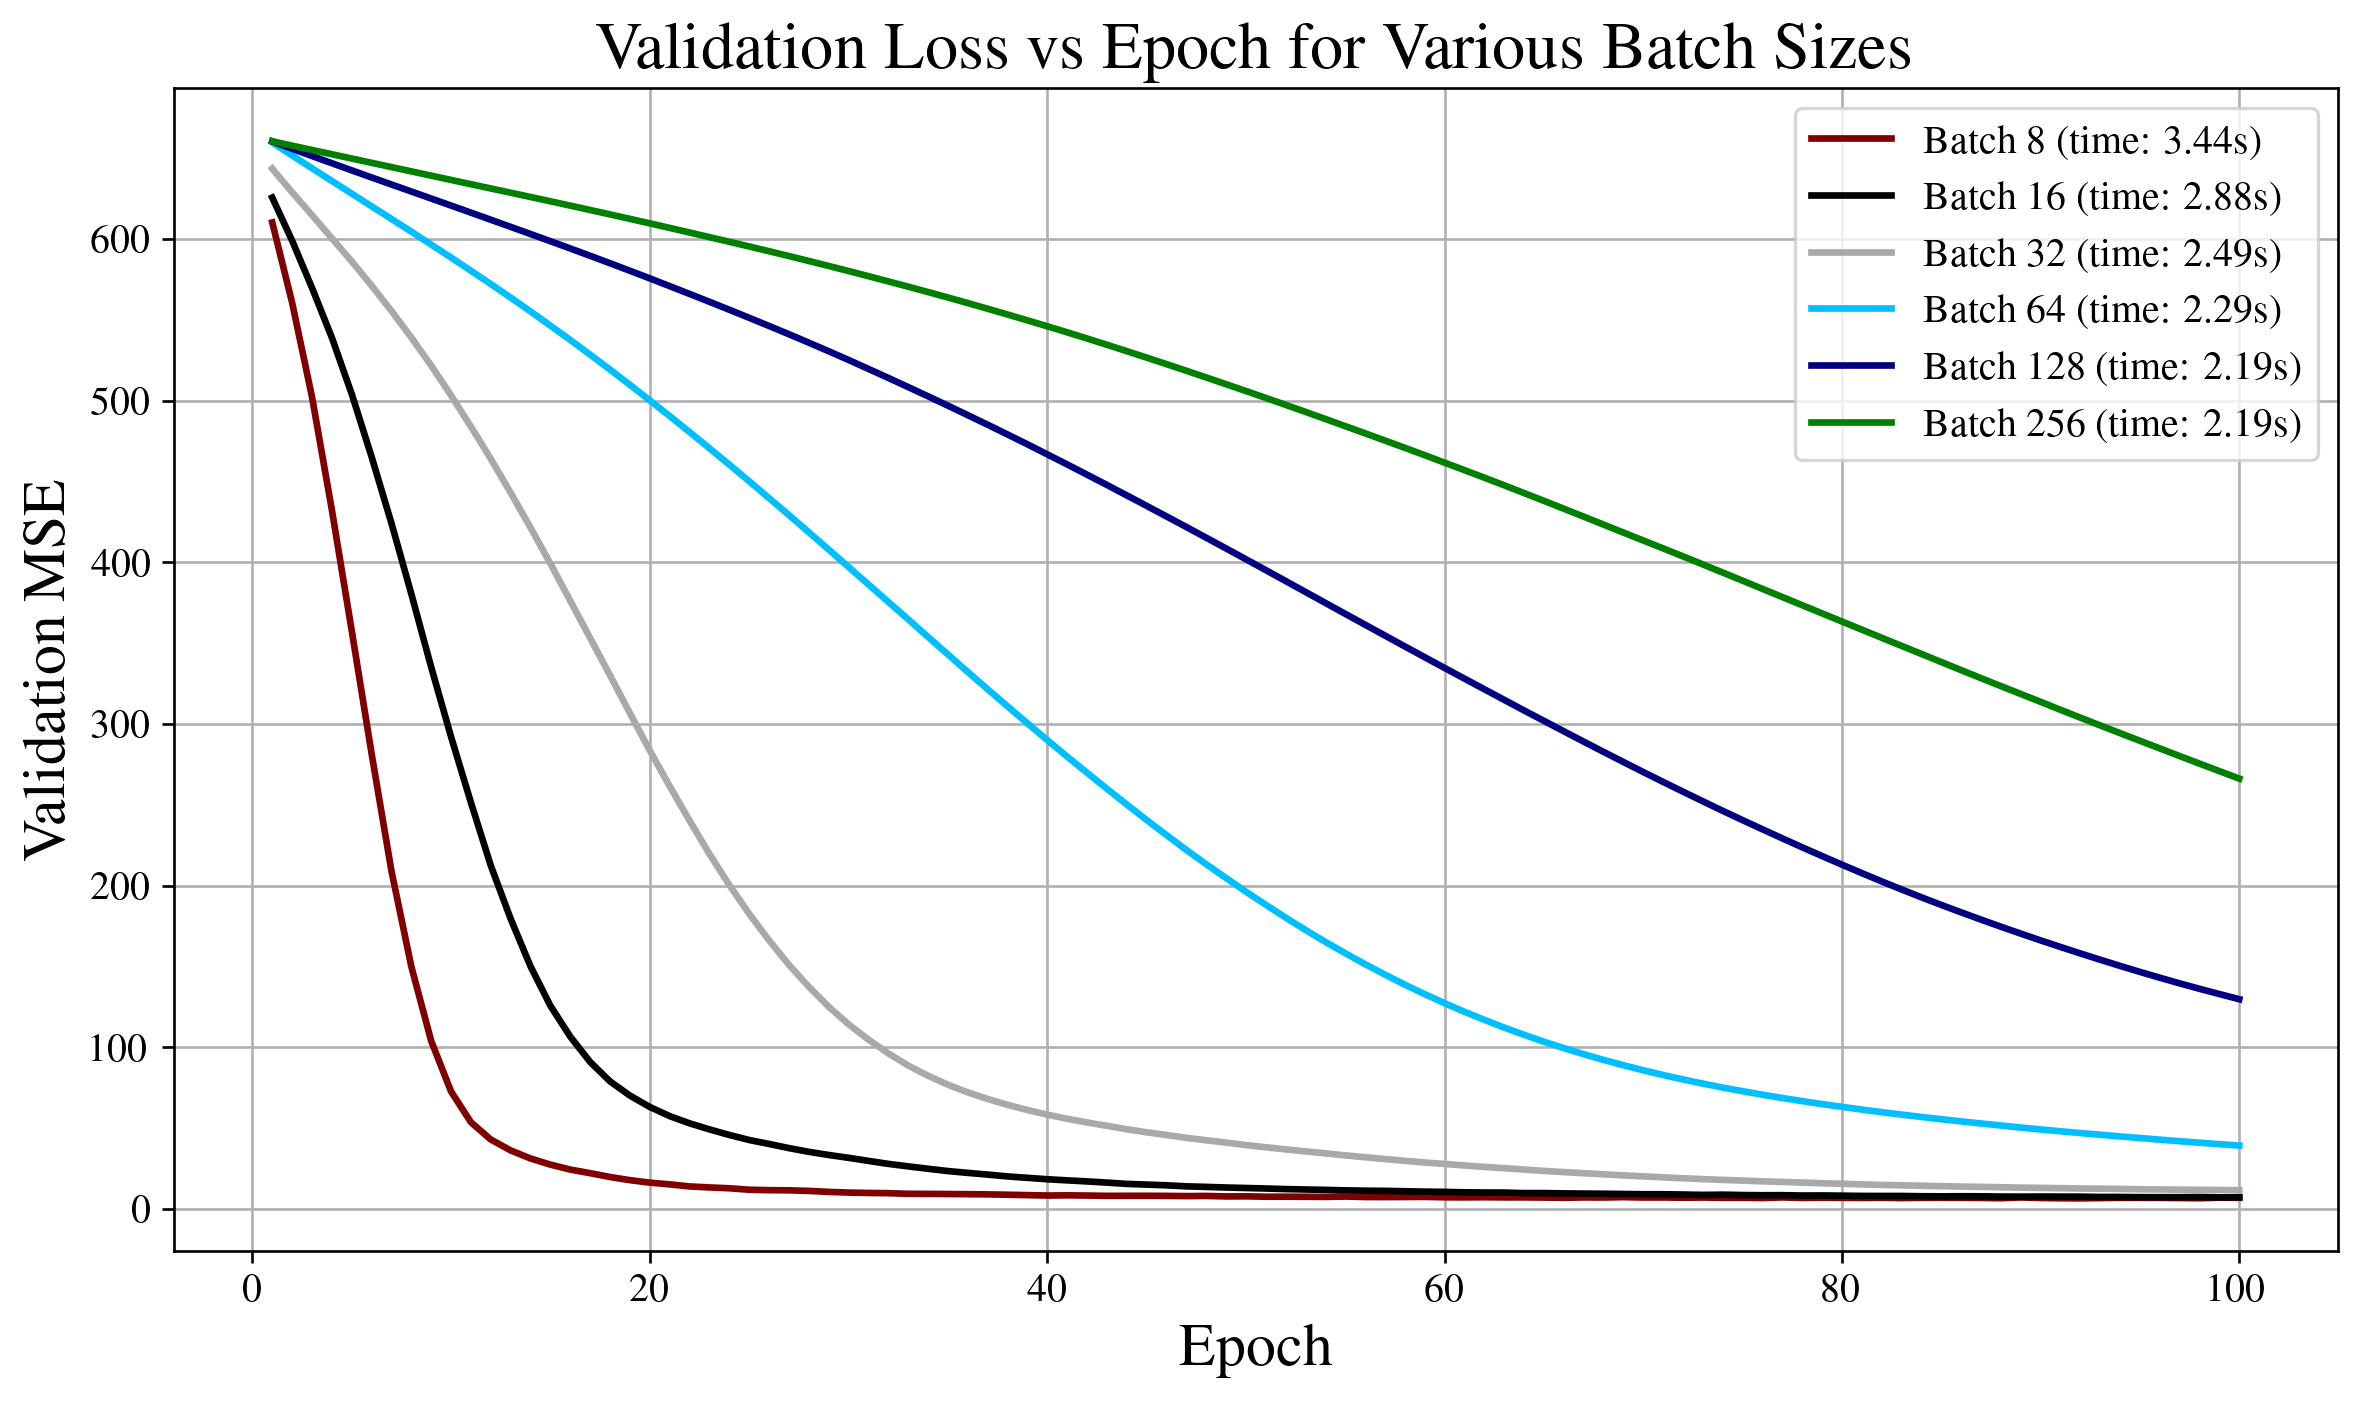

In [4]:
# Define a list of batch sizes (all ≤ 313, which is the training set size)
batch_sizes = [8, 16, 32, 64, 128, 256]

training_times_dict = {}
histories = {}

for bs in batch_sizes:
    k.clear_session()  # Ensure each run starts fresh

    # Build a fresh model for this batch size
    model = Sequential([
        Input(shape=(x_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    start_time = time.perf_counter()
    history = model.fit(x_train, y_train, epochs=100,
                        validation_data=(x_test, y_test),
                        batch_size=bs, verbose=False)
    elapsed_time = time.perf_counter() - start_time

    training_times_dict[bs] = elapsed_time
    histories[bs] = history.history

    print(f"Batch Size: {bs}, Training Time: {elapsed_time:.2f} sec, Final Training Loss: {history.history['loss'][-1]:.4f}")

fig, ax = plt.subplots()
for bs in batch_sizes:
    val_loss = histories[bs]['val_loss']
    elapsed_time = training_times_dict[bs]
    epochs_range = range(1, len(train_loss) + 1)

    ax.plot(epochs_range, val_loss, label=f'Batch {bs} (time: {elapsed_time:.2f}s)')

ax.set_xlabel('Epoch')
ax.set_ylabel('Validation MSE')
ax.set_title('Validation Loss vs Epoch for Various Batch Sizes')
ax.legend()
plt.show()

Smaller batch sizes, such as 8 or 16, lead to noisier gradient updates that can help the model converge in fewer epochs and achieve a lower validation loss. Although each epoch may take slightly longer with smaller batches, the overall training can be more efficient since fewer epochs are required for convergence. In contrast, larger batch sizes speed up per-epoch training but often result in a higher validation loss and require more epochs to reach comparable performance.

# Problem 3
Vary the number of hidden layers (up to at least 3) and the number of neurons in each layer (up to at least 256). What relationship do you observe between these meta parameters and training time, accuracy, validation accuracy, and overfitting?

## Solution

1 layer, 64 neurons: Time: 2.68 sec, Final Train Loss: 12.3987, Final Val Loss: 11.3793
2 layers, 64 neurons: Time: 2.99 sec, Final Train Loss: 7.2283, Final Val Loss: 7.1917
3 layers, 64 neurons: Time: 2.75 sec, Final Train Loss: 5.9963, Final Val Loss: 6.2607
2 layers, 128 neurons: Time: 2.63 sec, Final Train Loss: 6.6581, Final Val Loss: 6.9248
3 layers, 256 neurons: Time: 3.21 sec, Final Train Loss: 3.9764, Final Val Loss: 7.3245
3 layers, 512 neurons: Time: 5.44 sec, Final Train Loss: 2.6798, Final Val Loss: 7.7965
4 layers, 1024 neurons: Time: 10.24 sec, Final Train Loss: 2.6083, Final Val Loss: 6.7648


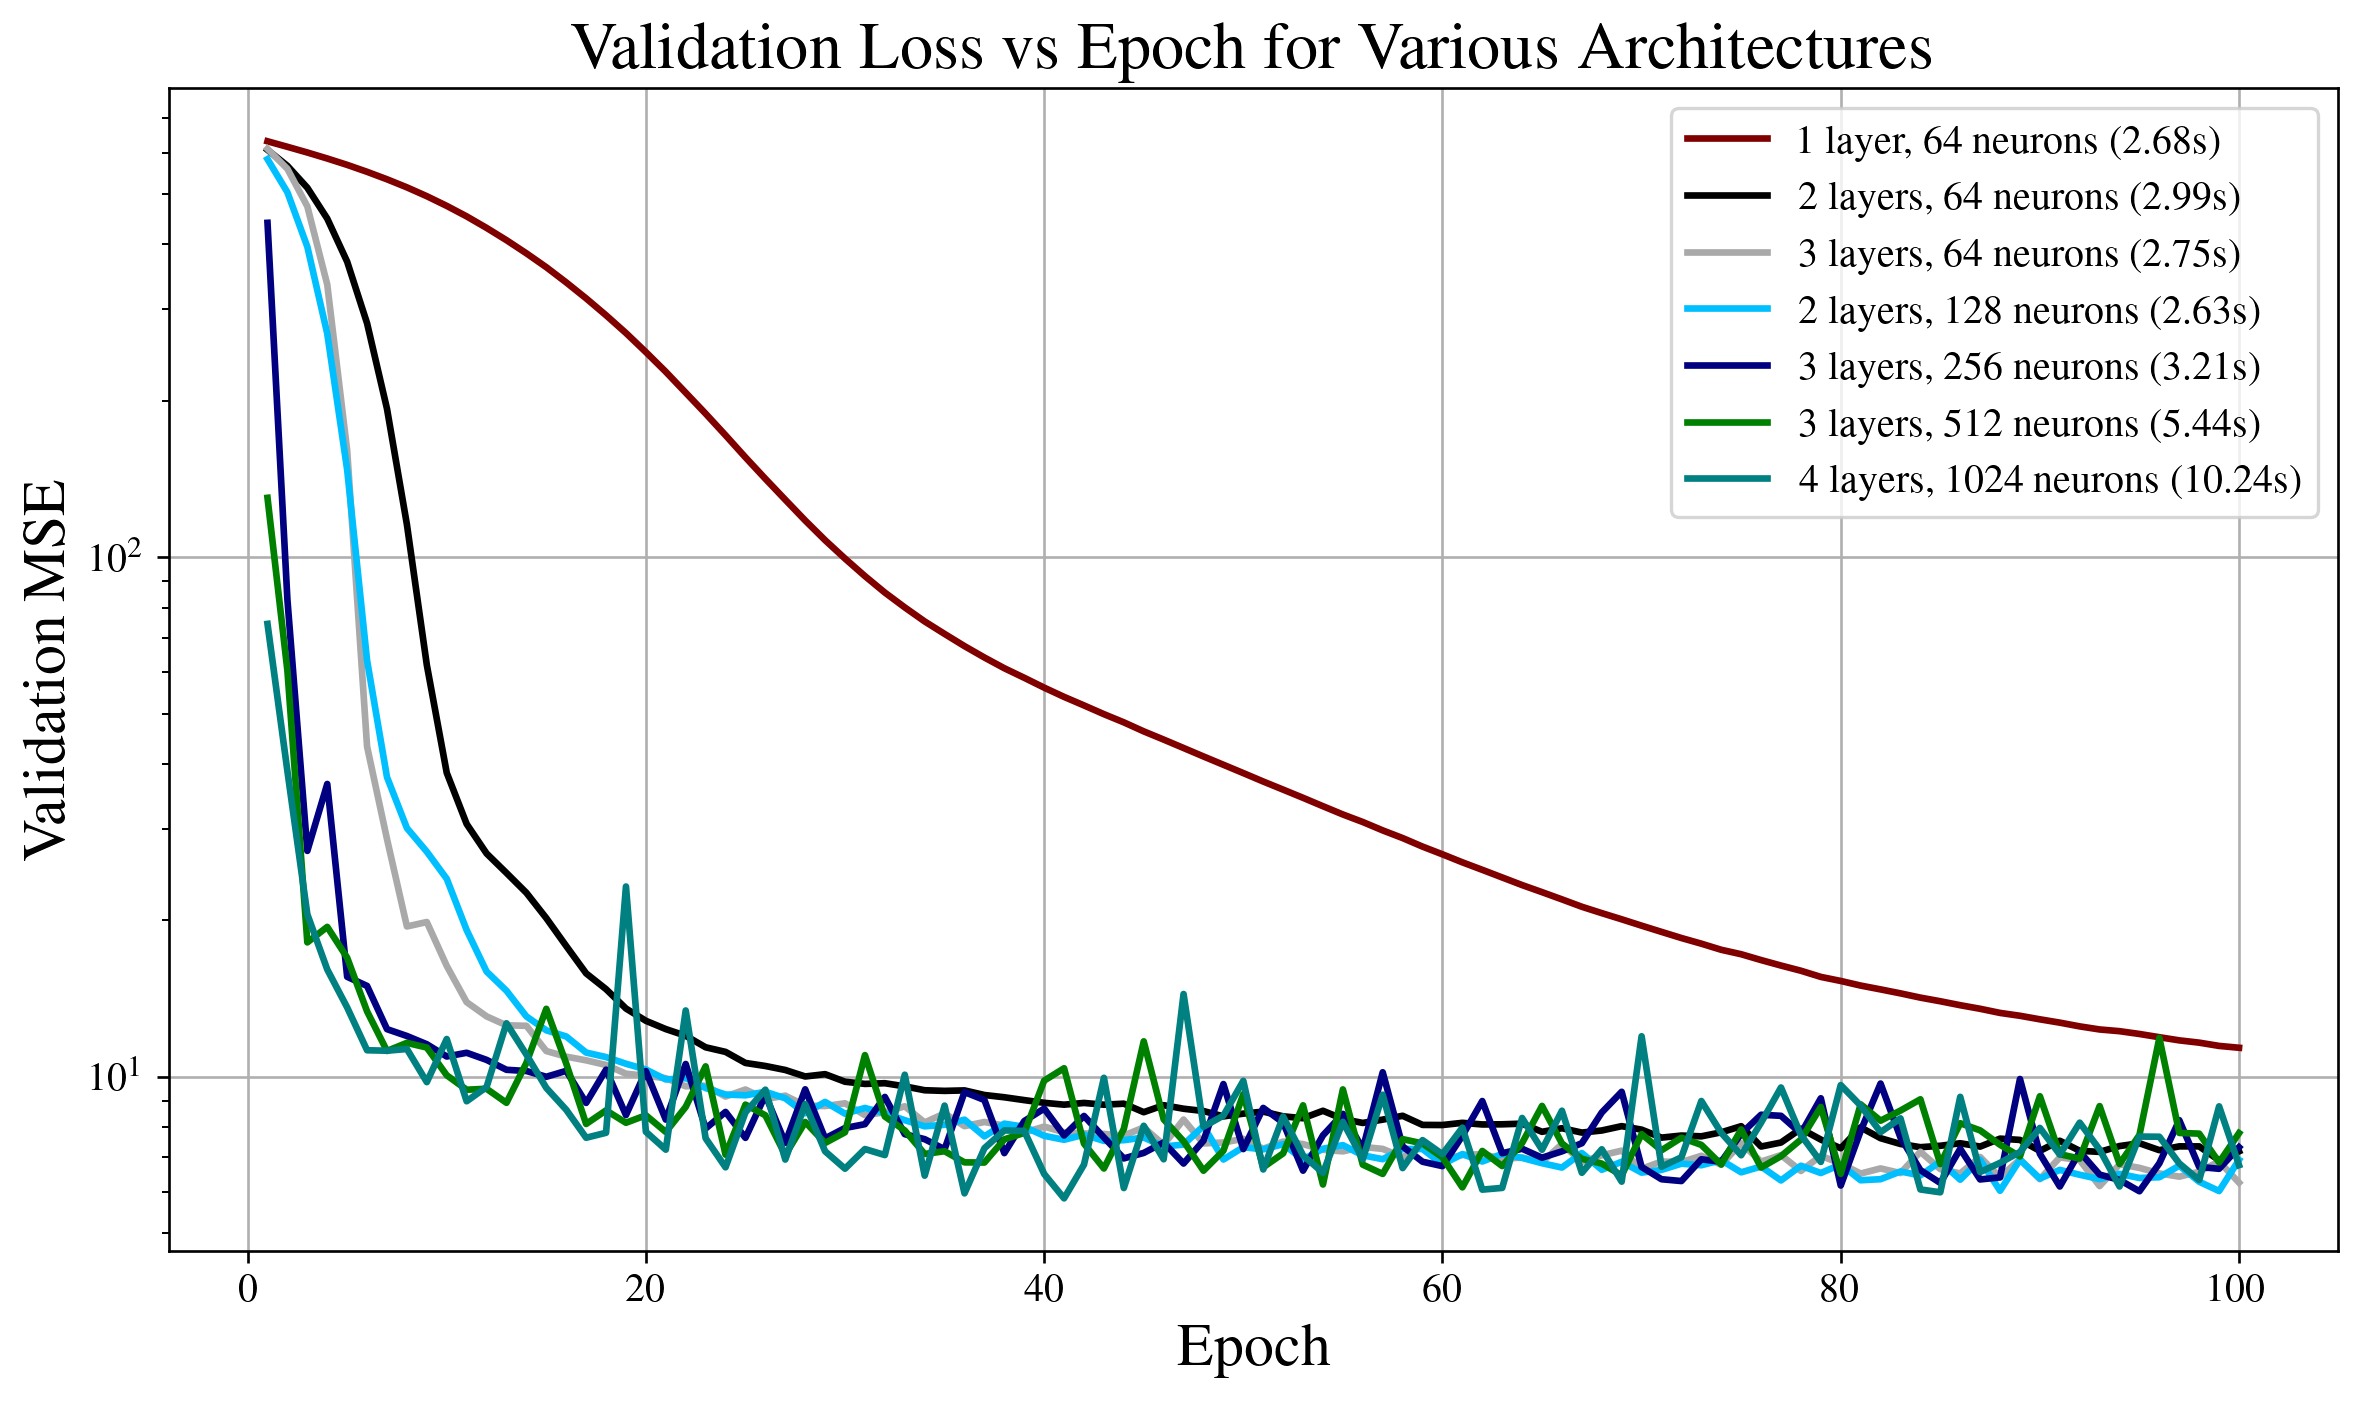

In [5]:
# Define different architectures to test.
architectures = [
    {"name": "1 layer, 64 neurons", "layers": 1, "neurons": 64},
    {"name": "2 layers, 64 neurons", "layers": 2, "neurons": 64},
    {"name": "3 layers, 64 neurons", "layers": 3, "neurons": 64},
    {"name": "2 layers, 128 neurons", "layers": 2, "neurons": 128},
    {"name": "3 layers, 256 neurons", "layers": 3, "neurons": 256},
    {"name": "3 layers, 512 neurons", "layers": 4, "neurons": 512},
    {"name": "4 layers, 1024 neurons", "layers": 4, "neurons": 1024},
]

# Dictionary to store history and training time for each architecture.
arch_results = {}
epoch_num = 100

for arch in architectures:
    k.clear_session()  # Reset the session to ensure a fresh model

    layers_list = [Input(shape=(x_train.shape[1],))]
    for _ in range(arch["layers"]):
        layers_list.append(Dense(arch["neurons"], activation='relu'))
    layers_list.append(Dense(1))

    model = Sequential(layers_list)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])

    start_time = time.perf_counter()
    history = model.fit(x_train, y_train, epochs=epoch_num,
                        validation_data=(x_test, y_test),
                        verbose=False, batch_size=32)
    elapsed_time = time.perf_counter() - start_time

    arch_results[arch["name"]] = {
        "history": history.history,
        "time": elapsed_time
    }

    print(f"{arch['name']}: Time: {elapsed_time:.2f} sec, "
          f"Final Train Loss: {history.history['loss'][-1]:.4f}, "
          f"Final Val Loss: {history.history['val_loss'][-1]:.4f}")

# Plot the training and validation loss vs. epoch curves for all architectures.
fig, ax = plt.subplots(figsize=(10, 6))

epochs_range = range(1, epoch_num + 1)
for arch_name, result in arch_results.items():
    ax.plot(epochs_range, result["history"]["val_loss"], label=f'{arch_name} ({result["time"]:.2f}s)')

ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.set_ylabel('Validation MSE')
ax.set_title('Validation Loss vs Epoch for Various Architectures')
ax.legend()
plt.show()

The results clearly show that as the network complexity increases, so does the training time, due to the higher number of parameters being optimized. While more complex models can reduce the training loss significantly, they also exhibit signs of overfitting, as evidenced by a rising validation loss and increased noise in the loss curves starting at the 3 layers, 256 neuron scheme. This increased noise indicates that the model begins to capture non-generalizable patterns from the training data, compromising its performance on unseen data. It looks like the 2 layers, 128 neurons model or 3 layers, 64 neurons offer a good trade-off.

# Problem 4
Construct the best architecture you can for fitting the provided dataset. You will want to use an 80/10/10 train/validation/test split. Remember, the validation set is for comparing different meta parameters, while the test set gives you the accuracy of your final result. What is the best model you can make and what is its error?

## Solution

Test MSE: 6.6016


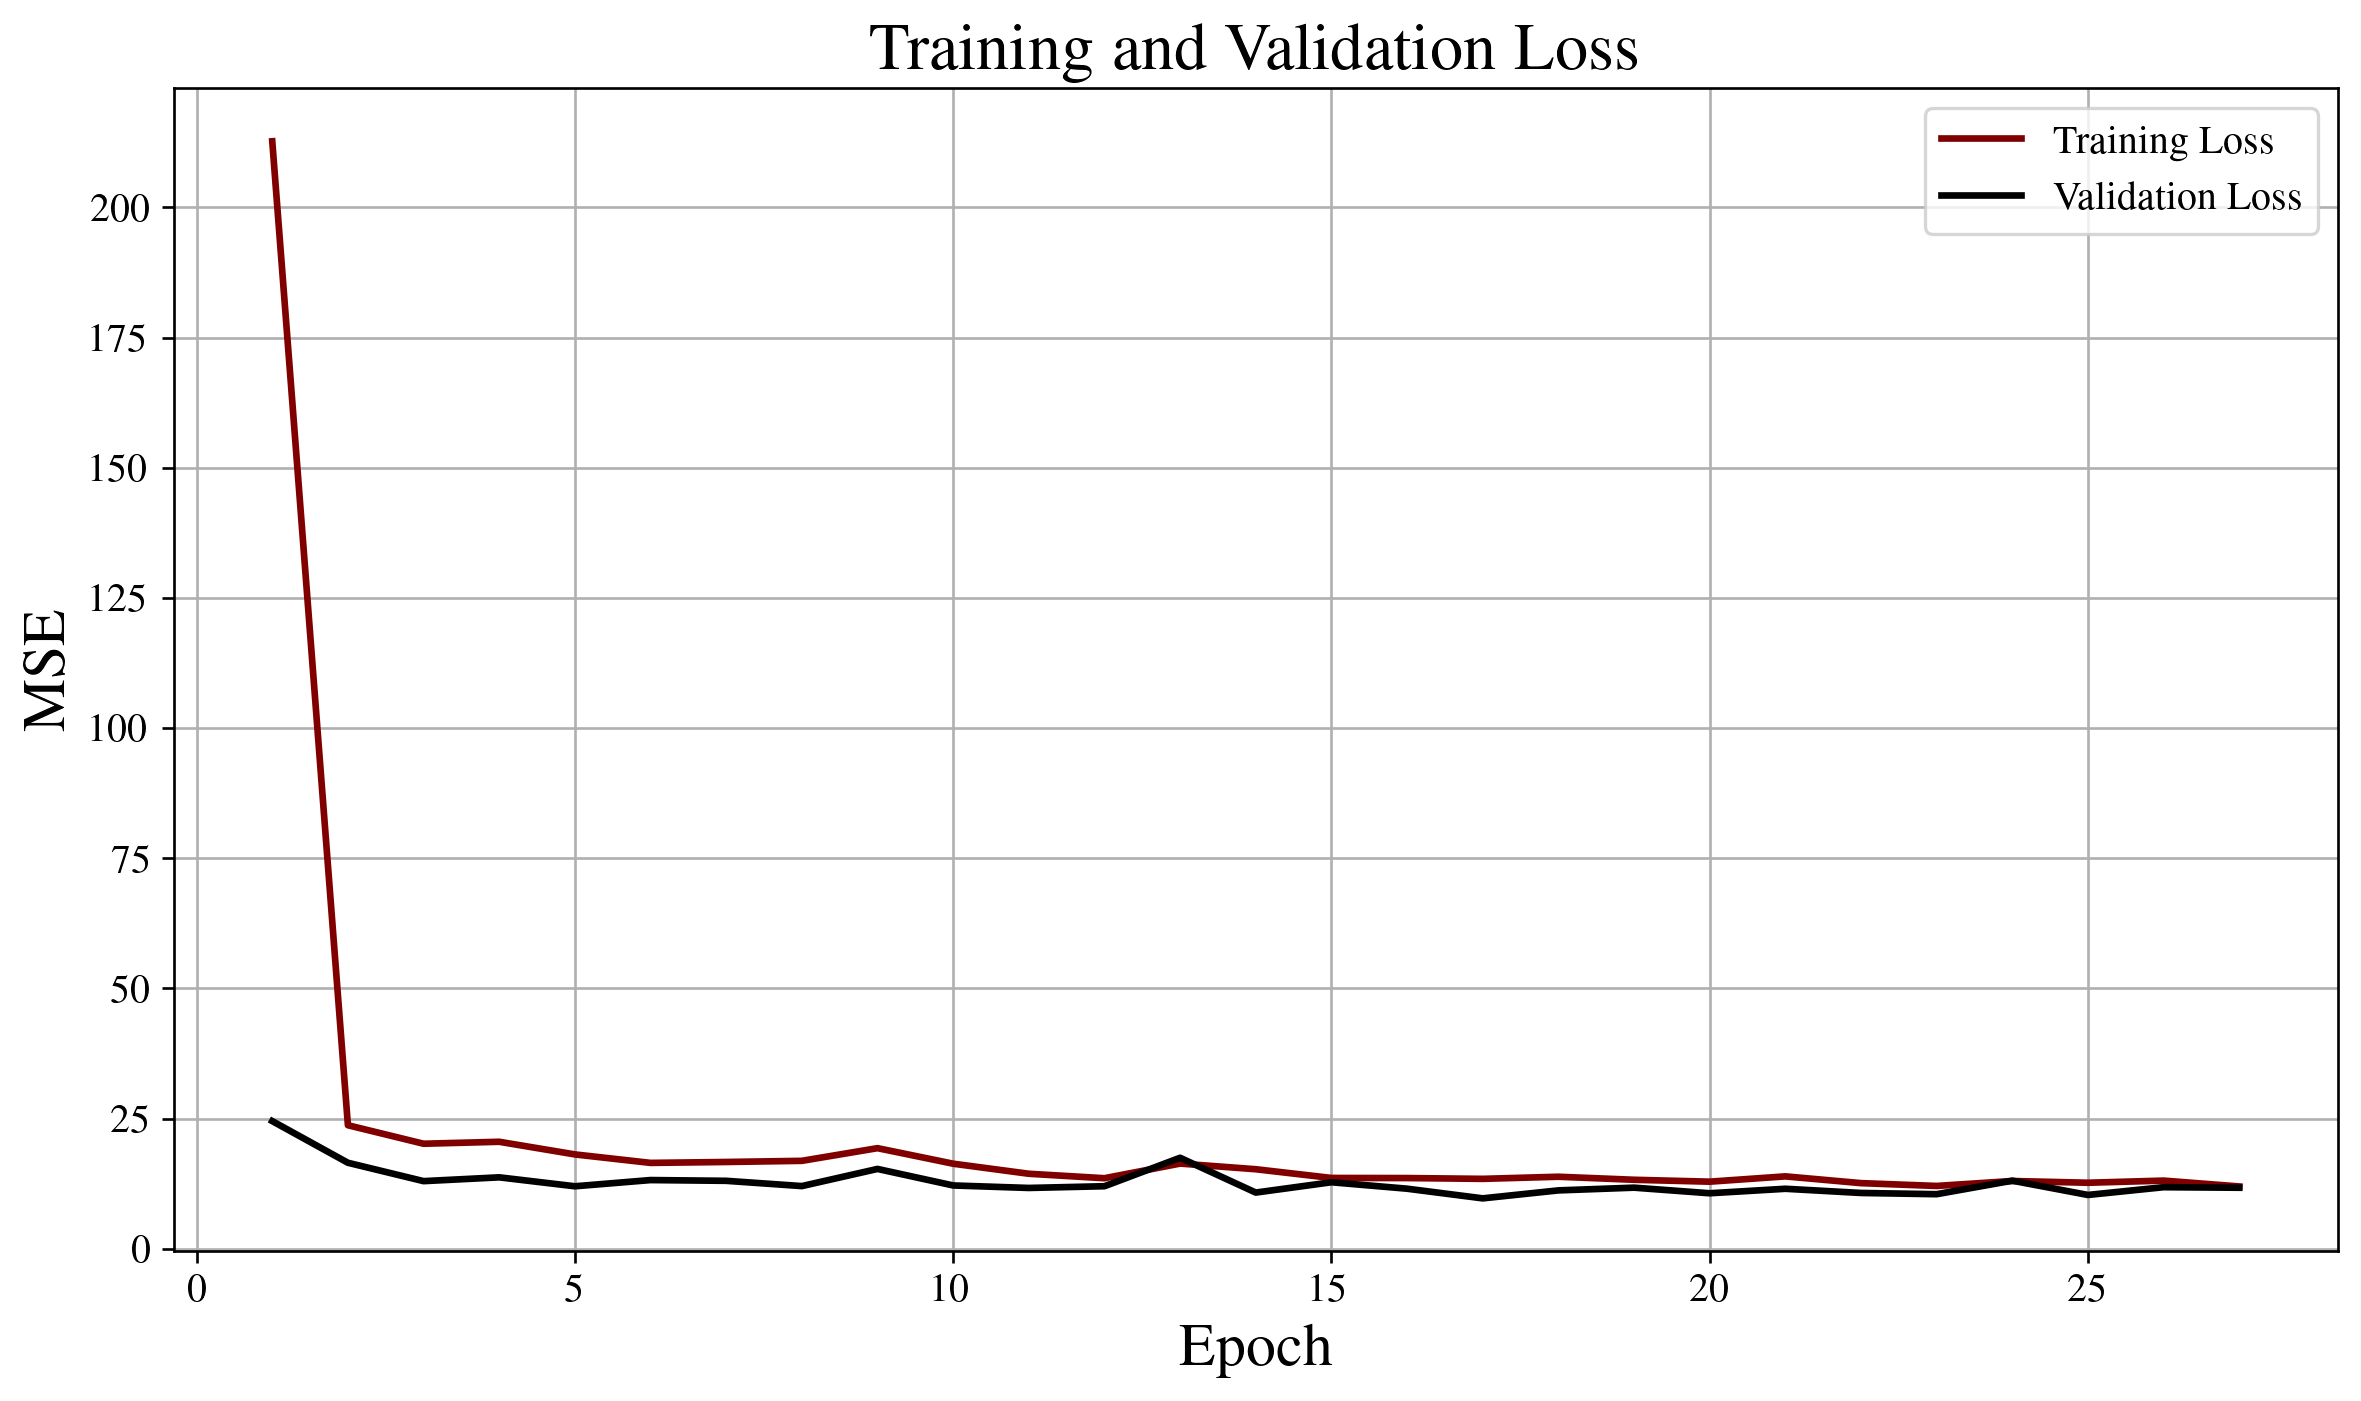

,100,1,168,355,260
cylinders,6.000000,8.000000,4.000000,6.000000,8.000000
displacement,198.000000,350.000000,140.000000,145.000000,305.000000
horsepower,95.000000,165.000000,78.000000,76.000000,145.000000
weight,2904.000000,3693.000000,2592.000000,3160.000000,3425.000000
acceleration,16.000000,11.500000,18.500000,19.600000,13.200000
model_year,73.000000,70.000000,75.000000,81.000000,78.000000
origin,1.000000,1.000000,1.000000,2.000000,1.000000
mpg actual,23.000000,15.000000,23.000000,30.700000,19.200000
mpg predicted,20.009062,14.053758,23.886806,30.605568,17.431549


In [9]:
# Re-split the data into 80% training, 10% validation, 10% test.
# First, split into training (80%) and temporary (20%).
train_data, temp_data, train_target, temp_target = train_test_split(features, target, test_size=0.2)

# Then split the temporary set equally into validation (10%) and test (10%).
val_data, test_data, val_target, test_target = train_test_split(temp_data, temp_target, test_size=0.5)

# Scale
scaler = StandardScaler()
x_train = scaler.fit_transform(train_data)
x_val = scaler.transform(val_data)
x_test = scaler.transform(test_data)

# The target values remain unscaled
y_train = train_target
y_val = val_target
y_test = test_target

# Clear previous session to ensure a fresh model
k.clear_session()

# Build the best model architecture identified from previous experiments.
# Here, we use a model with 2 hidden layers of 128 neurons each.
model = Sequential([
    Input(shape=(x_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Create callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train
history = model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val),
                    verbose=False, batch_size=2, callbacks=[early_stop, checkpoint])

# Evaluate the final model on the test set.
test_loss, test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.4f}")

# Plot the training and validation loss vs. epoch curves for the final model.
fig, ax = plt.subplots()
ax.plot(np.array(history.epoch) + 1, history.history['loss'], label='Training Loss')
ax.plot(np.array(history.epoch) + 1, history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE')
ax.set_title('Training and Validation Loss')
ax.legend()
plt.show()

# Showing predicted values in the test data
predictions = model.predict(x_test, verbose=0)
df_test = pd.DataFrame(test_data, columns=features.columns)
df_test['mpg actual'] = y_test.values
df_test['mpg predicted'] = predictions

df_test.head().transpose()

I took the better optimized hyperparameters from the previous problem, but added dropout layers to prevent overfitting and memorizing the training data. For some runs, the validation loss is actually better than the training loss. Regardless, the best I can get it is an MSE between 5MPG and 10MPG.